### 🔁 What is Iterative Retrieval in Agentic RAG?
Combined both Iterative And Self reflection

✅ Definition:
Iterative Retrieval is a dynamic strategy where an AI agent doesn't settle for the first batch of retrieved documents. Instead, it evaluates the adequacy of the initial context, and if necessary, it:

- Refines the query,
- Retrieves again,
- Repeats the process until it’s confident enough to answer the original question.

🧠 Why Use It?
In standard RAG:

- A single retrieval step is done, and the LLM uses it to answer.
- If the documents were incomplete or irrelevant, the answer may fail.

In Iterative RAG:

- The agent reflects on the retrieved content and the answer it produced.
- If it’s unsure, it can refine its search (like a human researcher would).

In [1]:
import os
from typing import List
from pydantic import BaseModel
from langchain_core.documents import Document
from langchain_community.document_loaders import TextLoader
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import StateGraph, END
from langchain_huggingface import HuggingFaceEmbeddings

d:\RAG\AgenticAI-LangGraph\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv
load_dotenv()

llm=init_chat_model("groq:openai/gpt-oss-20b")

In [5]:
### Load And Embed Documents
docs = TextLoader("research_notes.txt", encoding="utf-8").load()
chunks = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50).split_documents(docs)
vectorstore = FAISS.from_documents(chunks, HuggingFaceEmbeddings())
retriever = vectorstore.as_retriever()

In [6]:
### Define Agent State

class IterativeRAGState(BaseModel):
    question: str
    refined_question: str = ""
    retrieved_docs: List[Document] = []
    answer: str = ""
    verified: bool = False
    attempts: int = 0


In [7]:
### Retrieve Node
def retrieve_docs(state: IterativeRAGState) -> IterativeRAGState:
    query = state.refined_question or state.question
    docs = retriever.invoke(query)
    return state.model_copy(update={"retrieved_docs": docs})


In [8]:
### Reflect And Verify
def generate_answer(state: IterativeRAGState) -> IterativeRAGState:
    
    context = "\n\n".join(doc.page_content for doc in state.retrieved_docs)
    prompt = f"""Use the following context to answer the question:

Context:
{context}

Question:
{state.question}
"""
    response = llm.invoke(prompt.strip()).content.strip()
    return state.model_copy(update={"answer": response, "attempts": state.attempts + 1})

In [9]:
## Reflect on answer
def reflect_on_answer(state: IterativeRAGState) -> IterativeRAGState:
    
    prompt = f"""
Evaluate whether the answer below is factually sufficient and complete.

Question: {state.question}
Answer: {state.answer}

Respond 'YES' if it's complete, otherwise 'NO' with feedback.
"""
    feedback = llm.invoke(prompt).content.lower()
    verified = "yes" in feedback
    return state.model_copy(update={"verified": verified})


In [10]:
## Refine query
def refine_query(state: IterativeRAGState) -> IterativeRAGState:
    
    prompt = f"""
The answer appears incomplete. Suggest a better version of the query that would help retrieve more relevant context.

Original Question: {state.question}
Current Answer: {state.answer}
"""
    new_query = llm.invoke(prompt).content.strip()
    return state.model_copy(update={"refined_question": new_query})


In [11]:
builder = StateGraph(IterativeRAGState)

builder.add_node("retrieve", retrieve_docs)
builder.add_node("answer", generate_answer)
builder.add_node("reflect", reflect_on_answer)
builder.add_node("refine", refine_query)

builder.set_entry_point("retrieve")
builder.add_edge("retrieve", "answer")
builder.add_edge("answer", "reflect")

builder.add_conditional_edges(
    "reflect",
    lambda s: END if s.verified or s.attempts >= 2 else "refine"
)

builder.add_edge("refine", "retrieve")
builder.add_edge("answer", END)

graph = builder.compile()


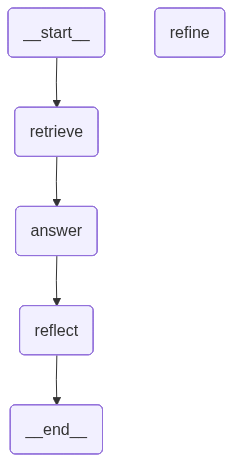

In [12]:
graph

In [13]:
query = "agent loops  and transformer-based systems?"

initial_state = IterativeRAGState(question=query)
final = graph.invoke(initial_state)

print("✅ Final Answer:\n", final["answer"])
print("\n🧠 Verified:", final["verified"])
print("🔁 Attempts:", final["attempts"])


✅ Final Answer:
 ## Agent Loops & Transformer‑Based Systems  
*(A concise primer that ties together the papers and concepts you listed)*

| Concept | What it is | How Transformers fit in | Typical use‑cases | Key papers |
|---------|------------|------------------------|-------------------|------------|
| **Agent Loop** | A closed‑loop interaction cycle where an “agent” (model + policy) receives observations, produces actions, and updates its state. Often expressed as <br>**Observation → Decision → Action → Environment → Observation** | The **Decision** step is usually a large language model (LLM) that “decides” what to do next. The LLM can be a vanilla Transformer or an augmented version (e.g., RAG, RLHF‑fine‑tuned). | Conversational assistants, autonomous agents in simulation, self‑improving systems (e.g., self‑debugging code generators). | *Language Models are Few‑Shot Learners*, *RLHF*, *Retrieval‑Augmented Generation* |
| **Transformer Backbone** | The core neural architecture tha

In [14]:
final

{'question': 'agent loops  and transformer-based systems?',
 'refined_question': '',
 'retrieved_docs': [Document(id='76c8d973-c56c-4203-ab39-c5326231b60e', metadata={'source': 'research_notes.txt'}, page_content='Key papers/reading (suggested)\n- "Attention Is All You Need"\n- "Scaling Laws for Neural Language Models"\n- "Language Models are Few-Shot Learners"\n- "Chain of Thought Prompting"\n- "Retrieval-Augmented Generation (RAG)"\n- "Reinforcement Learning from Human Feedback (RLHF)"\n- Survey papers on efficient / sparse Transformers'),
  Document(id='eb78a913-9615-483a-8361-06a860f61bae', metadata={'source': 'research_notes.txt'}, page_content='Scaling & Emergence\n- Scaling laws: predictable improvements with increased model size, data, and compute; compute-optimal configs matter.\n- Emergent capabilities arise at scale: robust reasoning, few-shot tasks, longer context handling.\n- Diminishing returns: data quality, compute efficiency, and fine-tuning strategies become critical 

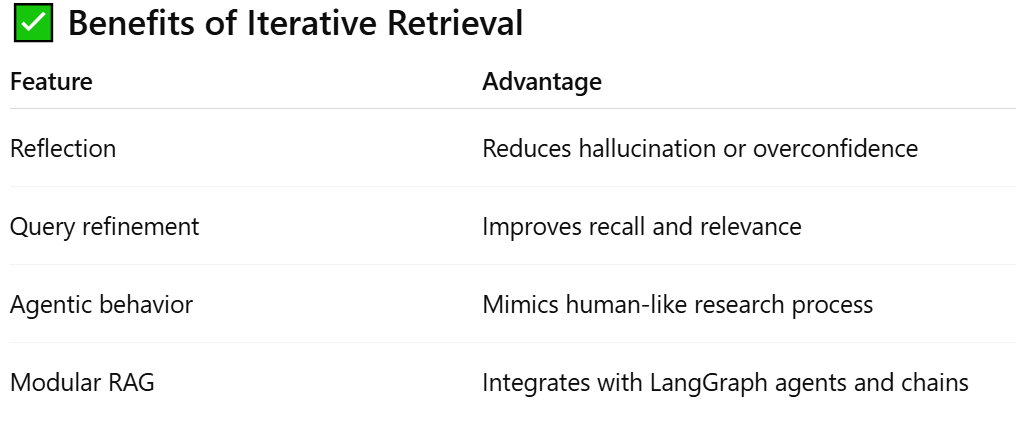